In [3]:
import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input
from tensorflow.python.keras.models import Model
import tensorflow_datasets as tfds

class CNN_AE(object):
    def __init__(self, layers_filters, input_shape):
        self.layers_filters = layers_filters
        self.input_shape = input_shape
        self.Encoder = None
        self.Model = None
        self.Decoder = None
        self.Model_Encoder = None
        self.input_layer = Input(shape=input_shape)
        self.history = None

    def build_model(self):
        self.__build_encoder()
        self.__build_decoder()

    def __build_encoder(self):
        cnn_layers = self.__get_layers()
        self.Encoder = cnn_layers[0](self.input_layer)
        self.Encoder = MaxPool2D(pool_size=(2, 2))(self.Encoder)
        for layer in cnn_layers[1:-1]:
            self.Encoder = layer(self.Encoder)
            self.Encoder = MaxPool2D(pool_size=(2, 2))(self.Encoder)
        self.Encoder = cnn_layers[-1](self.Encoder)
        encoder_visualization = Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(self.Encoder)
        self.Model_Encoder = Model(inputs=self.input_layer, outputs=encoder_visualization)

    def __build_decoder(self):
        if self.Encoder is None:
            return None
        cnn_layers = self.__get_layers()
        cnn_layers = (cnn_layers[::-1])
        cnn_layers = cnn_layers[1:]

        self.Decoder = cnn_layers[0](self.Encoder)
        self.Decoder = UpSampling2D(size=(2, 2))(self.Decoder)
        for layer in cnn_layers[1:]:
            self.Decoder = layer(self.Decoder)
            self.Decoder = UpSampling2D(size=(2, 2))(self.Decoder)
        self.Decoder = Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(self.Decoder)
        self.Model = Model(inputs=self.input_layer, outputs=self.Decoder)

    def fit(self,
            train,
            valid_ds,
            optimizer,
            loss,
            train_steps,
            valid_steps,
            epochs):
        try:
            self.Model.compile(loss=loss, optimizer=optimizer)
            self.history = self.Model.fit(train,
                                          steps_per_epoch=train_steps,
                                          validation_data=valid_ds,
                                          validation_steps=valid_steps,
                                          epochs=epochs)
        except Exception as E:
            print(E)

    def __get_layers(self):
        layers = []
        for i in self.layers_filters:
            layers.append(Conv2D(filters=i, kernel_size=(3, 3), padding='same', activation='relu'))
        return layers




def map_image(image, label):
  '''Normalizes the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image


def get_data():
    # Load the train and test sets from TFDS
    BATCH_SIZE = 128
    SHUFFLE_BUFFER_SIZE = 1024

    train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
    train_dataset = train_dataset.map(map_image)
    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
    test_dataset = test_dataset.map(map_image)
    test_dataset = test_dataset.batch(BATCH_SIZE).repeat()
    return train_dataset, test_dataset, BATCH_SIZE

if __name__ == '__main__':
    train_dataset,test_dataset,BATCH_SIZE = get_data()
    train_steps = 60000 // BATCH_SIZE
    valid_steps = 60000 // BATCH_SIZE
    filters = [64, 128, 256]
    model = CNN_AE(filters, (28, 28, 1))
    model.build_model()
    model.Model.summary()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteE3WNCZ/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteE3WNCZ/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         2

In [14]:
"""
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0

 conv2d (Conv2D)             (None, 28, 28, 64)        640

 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0
 )

 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856

 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0
 2D)

 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168

 conv2d_4 (Conv2D)           (None, 7, 7, 128)         295040

 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0
 )

 conv2d_5 (Conv2D)           (None, 14, 14, 64)        73792

 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0
 2D)

 conv2d_6 (Conv2D)           (None, 28, 28, 1)         577
"""
print()

In [4]:
model.fit(train_dataset,
            test_dataset,
            optimizer='adam',
            loss='binary_crossentropy',
            train_steps=train_steps,
            valid_steps=valid_steps,
            epochs=40)

Epoch 1/40
468/468 [==============================] - 22s 25ms/step - loss: 0.2895 - val_loss: 0.2664
Epoch 2/40
468/468 [==============================] - 10s 20ms/step - loss: 0.2602 - val_loss: 0.2596
Epoch 3/40
468/468 [==============================] - 10s 22ms/step - loss: 0.2554 - val_loss: 0.2557
Epoch 4/40
468/468 [==============================] - 10s 22ms/step - loss: 0.2529 - val_loss: 0.2538
Epoch 5/40
468/468 [==============================] - 10s 22ms/step - loss: 0.2514 - val_loss: 0.2527
Epoch 6/40
468/468 [==============================] - 11s 23ms/step - loss: 0.2504 - val_loss: 0.2518
Epoch 7/40
468/468 [==============================] - 10s 22ms/step - loss: 0.2497 - val_loss: 0.2512
Epoch 8/40
468/468 [==============================] - 10s 22ms/step - loss: 0.2491 - val_loss: 0.2507
Epoch 9/40
468/468 [==============================] - 11s 23ms/step - loss: 0.2486 - val_loss: 0.2508
Epoch 10/40
468/468 [==============================] - 11s 23ms/step - loss: 0.248

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

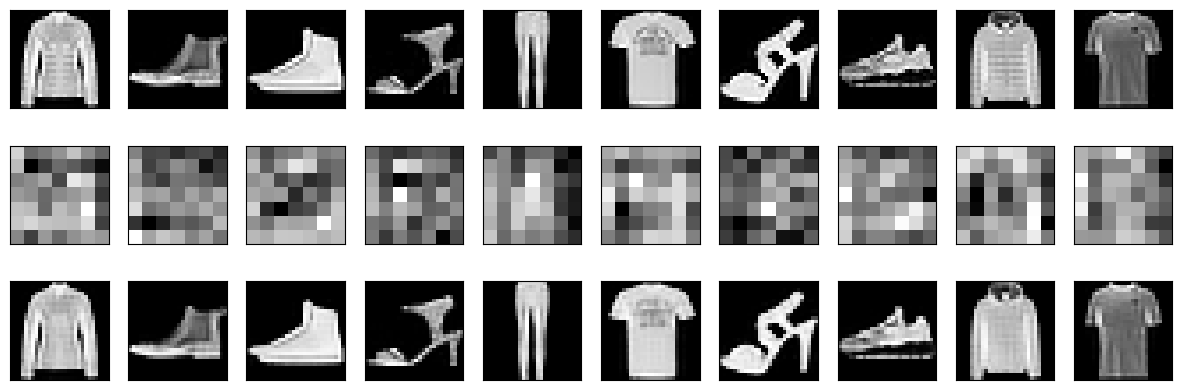

In [9]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = model.Model_Encoder.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = model.Model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))